# Electric Data Predict

## Colab Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 22 20:34:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX250      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

## Import Library

In [3]:
!pip install pytorch-lightning

     |████████████████████████████████| 686kB 25.2MB/s 
     |████████████████████████████████| 645kB 48.9MB/s 
     |████████████████████████████████| 829kB 60.8MB/s 
     |████████████████████████████████| 102kB 15.5MB/s 
     |████████████████████████████████| 1.3MB 58.1MB/s 
     |████████████████████████████████| 143kB 56.5MB/s 
     |████████████████████████████████| 296kB 55.3MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=95bd090c39f8c5e8b0306769ce1b77de574294e6f7ac6e377a520e48317dadd1
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=d903dc7a1829af58a5138dec3472d7796ebe9944721091408a68b5fa11e4e92f
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built future idna-ssl
  Found existing installation: PyYAML 3.13
    Unins

In [4]:
%cd drive/MyDrive/Research3/train

/content/drive/MyDrive/Research3/lib


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.metrics import functional as FM

import GetData
from BaseModel import BaseModel

## Define Model

In [10]:
class Model(BaseModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn = nn.LSTM(1, 128, 1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 1)
        )

    def forward(self, X):
        X, (hn, cn) = self.rnn(X)
        return self.fc(X[:, -1, :])
    
    def test_epoch_end(self, outputs):
        h, y = zip(*outputs)
        h = torch.flatten(torch.cat(h, 0)).cpu().numpy()
        y = torch.flatten(torch.cat(y, 0)).cpu().numpy()
        plt.scatter(y, h)
        plt.show()

## Train And Predict

In [13]:
data_module = GetData.ElectricData(24*30, batch_size=256)
model = Model(F.mse_loss, metrics_fn=[(FM.mean_absolute_error, 'mae')], lr=1e-3)
trainer = pl.Trainer(gpus=1, max_epochs=100)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [14]:
trainer.fit(model, datamodule=data_module)


  | Name | Type       | Params
------------------------------------
0 | rnn  | LSTM       | 67.1 K
1 | fc   | Sequential | 8.3 K 
------------------------------------
75.4 K    Trainable params
0         Non-trainable params
75.4 K    Total params


1

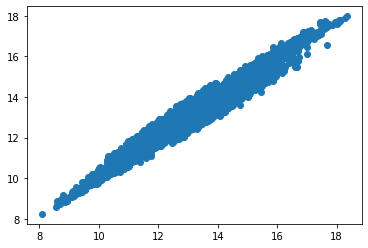


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss/test': tensor(0.0740, device='cuda:0'),
 'mae/test': tensor(0.1937, device='cuda:0')}
--------------------------------------------------------------------------------


[{'mae/test': 0.1937139928340912, 'loss/test': 0.0740080177783966}]

In [9]:
trainer.test(datamodule=data_module)